In [1]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from text3d2video.rendering import render_depth_map
from text3d2video.utilities.camera_placement import front_facing_extrinsics
from text3d2video.utilities.ipython_utils import display_ims
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import FoVOrthographicCameras

from text3d2video.utilities.mesh_processing import normalize_meshes

device = torch.device("cuda")

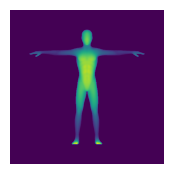

<Figure size 640x480 with 0 Axes>

In [39]:
animation = AnimationArtifact.from_wandb_artifact_tag("handstand:latest")
verts_uvs, faces_uvs = animation.uv_data()

meshes = load_objs_as_meshes(["data/meshes/mixamo-human.obj"]).to(device)
meshes = normalize_meshes(meshes)

R, T = front_facing_extrinsics(zs=1)
s = 1.5

cams = FoVOrthographicCameras(R=R, T=T, device=device, scale_xyz=[(s, s, s)])
meshes = meshes.extend(len(cams))

depth_map = render_depth_map(meshes, cams)[0]

display_ims([depth_map])

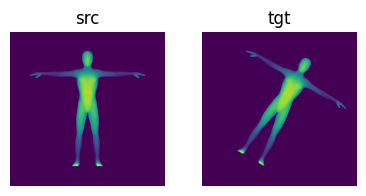

In [40]:
from text3d2video.utilities.image_utils import Affine2D


fun = Affine2D(angle=30)

display_ims([depth_map, fun(depth_map)], titles=["src", "tgt"])

In [41]:
from diffusers import ControlNetModel

from text3d2video.pipelines.controlnet_warped import WarpedControlNetPipeline
from diffusers import DPMSolverMultistepScheduler

device = torch.device("cuda")
dtype = torch.float16

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

controlnet = ControlNetModel.from_pretrained(controlnet_repo, torch_dtype=dtype).to(
    device
)

pipe = WarpedControlNetPipeline.from_pretrained(
    sd_repo, controlnet=controlnet, torch_dtype=dtype
).to(device)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:02<00:00, 14.81it/s]


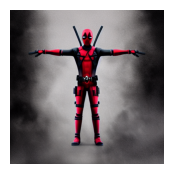

<Figure size 640x480 with 0 Axes>

: 

In [ ]:
from torch import Generator

gen = Generator(device=device)
gen.manual_seed(0)

ims = pipe("Deadpool", depth_map, fun, generator=gen)

display_ims(ims)